<img src='https://www.metro.us/sites/default/files/styles/normal_article_breakpoints_theme_metrous_desktop_1x/public/main/articles/2019/09/27/bianca_del_rio_2.jpeg'>

## Anonymous Ratings Data from the Jester Online Joke Recommender System

## Data source:
<br>
<p1>
    <b>Description: </b><br>Jester dataset is provided by berkeley university, freely available for research. <br>The data contains 4.1 Million continuous ratings (-10.00 to +10.00) of 100 jokes from 73,421 users: collected between April 1999 - May 2003.
</p1>
<br>
<p2>
<li> web link: <a>https://goldberg.berkeley.edu/jester-data/</a></li>
<li> Total users : 73421</li>
<li> Total jokes : 100</li>
<p2>

## Business problem:
<br>
<li>User will be recommended jokes from all available jokes in system.</li>
<li>There is no network latency as the jokes can be recommended to users over batch job.</li>
<li>The error metric is decided as NAME by the provider of data.</li>

## Error metric:
<br>
As per the requirement of the problem barkley university has choosen <b>NMAE</b>(Normalized Mean Absolute Error)
<br>

#### NMAE:

# $\frac{\frac{1}{n}\sum_{i}^{n}|(\widehat{y} - y)|}{max(y)-min(y)}$<b>

In [1]:
#import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
import os
import itertools
import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, BaselineOnly, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV

import random
from datetime import datetime
import pickle

from scipy import sparse
from scipy.sparse import csr_matrix

import xgboost as xgb
from xgboost import XGBRegressor


<br>

### 1.1 Data collection

In [2]:
#combine all 3 input files
raw_data = pd.DataFrame()
for i in os.listdir('./'):
    if(i.endswith('.xls')):
        tmp_data = pd.read_excel(i, header=None)
        print('length of records in %s is %s' %(len(tmp_data),i))
        raw_data = pd.concat([raw_data,tmp_data],axis=0)
print('Total lenth of records is '+str(len(raw_data)))

length of records in 24983 is jester-data-1.xls
length of records in 23500 is jester-data-2.xls
length of records in 24938 is jester-data-3.xls
Total lenth of records is 73421


In [3]:
raw_data_copy = raw_data.copy()
#raw_data = raw_data_copy.copy()

In [4]:
pickle.dump(raw_data_copy, open("dataframe.pickle","wb"))
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
print('Total number of users who rated all jokes are: ',len(raw_data[raw_data[0]==100]))

Total number of users who rated all jokes are:  14116


In [6]:
print('Total number of users who rated no jokes are: ',len(raw_data[raw_data[0]==0]))

Total number of users who rated no jokes are:  0


In [7]:
jokes_number_of_rating = []
for i in range(1,101):
    jokes_number_of_rating.append(len(raw_data[raw_data[i]!=99]))
#print(len(jokes_number_of_rating))

In [8]:
#sort jokes on number of jokes
jokes_number_of_rating = np.array(jokes_number_of_rating)
jokes_number_of_rating_arg_sort = np.argsort(jokes_number_of_rating)
jokes_number_of_rating_arg_sort = jokes_number_of_rating_arg_sort[::-1]
top_10_joke_id = jokes_number_of_rating_arg_sort[:25]
top_10_joke_id_rating = jokes_number_of_rating[top_10_joke_id]

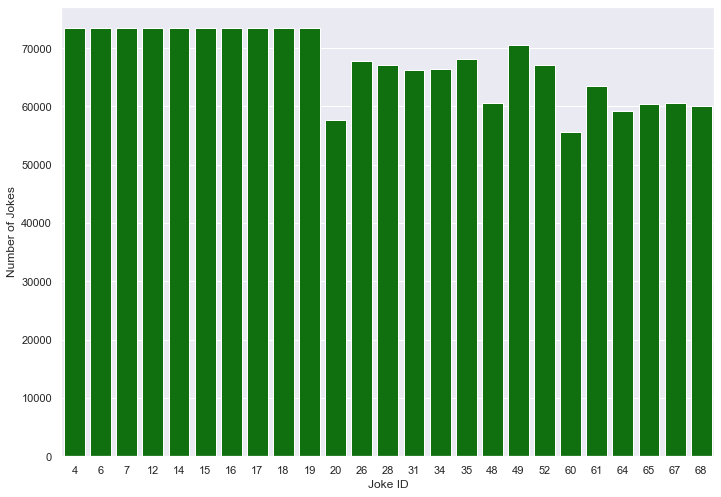

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(top_10_joke_id,top_10_joke_id_rating, color = 'green')
plot_is = ax.set(xlabel='Joke ID', ylabel='Number of Jokes')

### 1.2 Preparing data in format of ['user','joke', 'rating'] and data cleaning

In [10]:
#column 0 contains the number of ratings given by the user which is not useful.
number_of_rating = raw_data.drop(columns=[0])

In [11]:
raw_data.drop(columns=[0],inplace=True)
raw_data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [12]:
# we will not consider any rating which is 99.00 as it means the user has not rated the joke previously
list_data=[]
for i, j in raw_data.iterrows():
    #print(i)
    temp=[]
    for p,q in enumerate(j.values):
        #print(p+1)
        #print(q)
        if(q !=99.0):
            temp=[i,p,q]
            list_data.append(temp)
print(len(list_data))

4136360


In [13]:
formated_data = pd.DataFrame(list_data, columns=['user','joke','rating'])

In [14]:
# we will increase the joke id and user id by 1 as it does not feel good as user id 0
formated_data['user'] = formated_data['user'] + 1 
formated_data['joke'] = formated_data['joke'] + 1

<br>

### 2. Trin test split

In [15]:
#split the data as in a ratio of 70:30
train_df,test_df = train_test_split(formated_data, test_size=0.3, random_state=42)

In [16]:
print("Train size: ", train_df.shape)
print("test size: ", test_df.shape)

Train size:  (2895452, 3)
test size:  (1240908, 3)


<br>

### 3. Feature engineering

#### 3.1 Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [17]:
#finding global average train
print("global average of train is: ", train_df.rating.mean())

global average of train is:  0.739790630271198


In [18]:
#finding global average test
print("global average of test is: ", test_df.rating.mean())

global average of test is:  0.747643548111544


In [19]:
#find average user rating per user train 
train_df_grp_user = train_df.groupby(by='user')
train_average_user_rating={}
for i , j in train_df_grp_user:
    train_average_user_rating[i]=j.rating.mean()
print("Total number of train users: ", len(train_df_grp_user))

Total number of train users:  24983


In [20]:
#find average user rating per user test 
test_df_grp_user = test_df.groupby(by='user')
test_average_user_rating={}
for i , j in test_df_grp_user:
    test_average_user_rating[i]=j.rating.mean()
print("Total number of train users: ", len(test_df_grp_user))

Total number of train users:  24983


In [21]:
#find average joke rating per joke train
train_df_grp_joke = train_df.groupby(by='joke')
train_average_joke_rating={}
for i , j in train_df_grp_joke:
    train_average_joke_rating[i]=j.rating.mean()
print("Total number of jokes in train: ", len(train_df_grp_joke))

Total number of jokes in train:  100


In [22]:
#find average joke rating per joke test
test_df_grp_joke = test_df.groupby(by='joke')
test_average_joke_rating={}
for i , j in test_df_grp_joke:
    test_average_joke_rating[i]=j.rating.mean()
print("Total number of jokes in test: ", len(test_df_grp_joke))

Total number of jokes in test:  100


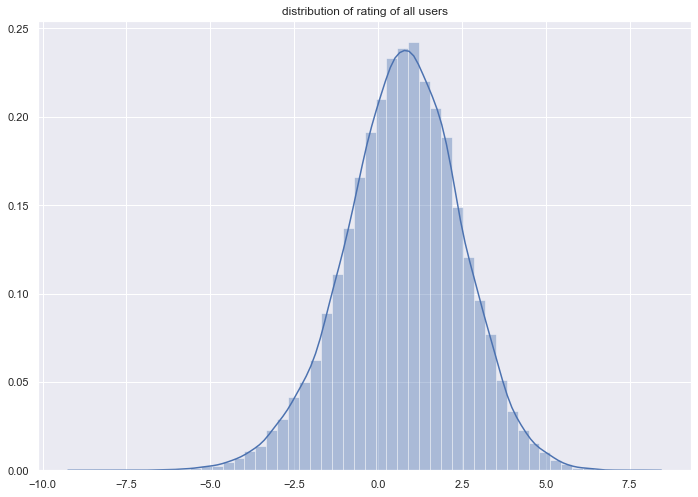

In [23]:
ax = sns.distplot([*train_average_user_rating.values()])
plot_is = ax.set(title='distribution of rating of all users')

In [24]:
print("Mean value of average rating of users is: ", np.mean([*train_average_user_rating.values()]))

Mean value of average rating of users is:  0.7277005724312704


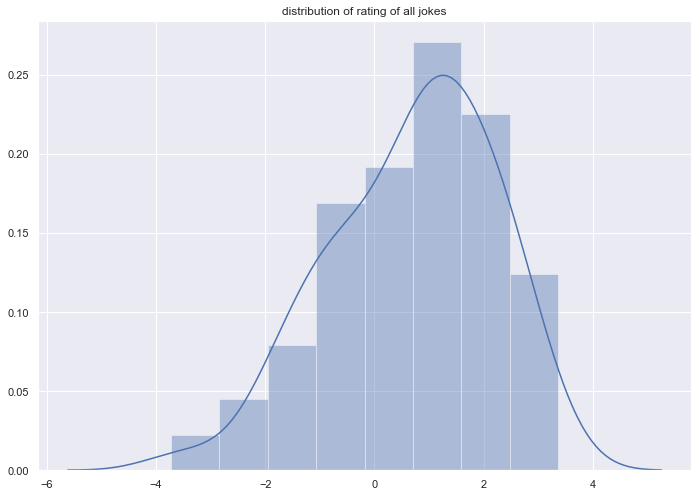

In [25]:
ax = sns.distplot([*train_average_joke_rating.values()])
plot_is = ax.set(title='distribution of rating of all jokes')

In [26]:
print("Mean value of average rating of jokes is: ", np.mean([*train_average_joke_rating.values()]))

Mean value of average rating of jokes is:  0.6999030393527355


### 4. create data frame strure to pass through ML models

In [27]:
# train dataframe
train_df_structured = train_df.copy()
train_df_structured['user_avg'] = train_df_structured.user.apply(lambda x: train_average_user_rating[x])
train_df_structured['joke_avg'] = train_df_structured.joke.apply(lambda x: train_average_joke_rating[x])
train_df_structured['gavg'] = 0.73979
train_df_structured.head()

,user,joke,rating,user_avg,joke_avg,gavg
2064504,3526,47,-0.24,-2.990463,1.322097,0.73979
313132,4371,49,-5.10,-0.362000,2.526823,0.73979
555676,7699,25,5.87,3.893030,0.434044,0.73979
4049155,21371,7,-2.91,1.447450,-0.657305,0.73979
1646072,22719,83,-0.58,3.784375,1.961670,0.73979


In [28]:
pickle.dump(train_df_structured, open("train_df_structured.pickle","wb"))
train_df_structured.head()

,user,joke,rating,user_avg,joke_avg,gavg
2064504,3526,47,-0.24,-2.990463,1.322097,0.73979
313132,4371,49,-5.10,-0.362000,2.526823,0.73979
555676,7699,25,5.87,3.893030,0.434044,0.73979
4049155,21371,7,-2.91,1.447450,-0.657305,0.73979
1646072,22719,83,-0.58,3.784375,1.961670,0.73979


In [29]:
# test dataframe
test_df_structured = test_df.copy()
test_df_structured['user_avg'] = test_df_structured.user.apply(lambda x: test_average_user_rating[x])
test_df_structured['joke_avg'] = test_df_structured.joke.apply(lambda x: test_average_joke_rating[x])
test_df_structured['gavg'] = 0.74764
test_df_structured.head()

,user,joke,rating,user_avg,joke_avg,gavg
1265657,17469,61,6.80,-0.077273,2.113085,0.74764
1297014,17897,45,-0.78,-2.413220,1.018350,0.74764
1567900,21640,47,-8.16,-1.552368,1.374515,0.74764
3232032,19559,48,5.05,-0.282558,1.741960,0.74764
810243,11231,76,3.88,0.034872,2.365746,0.74764


In [30]:
pickle.dump(test_df_structured, open("test_df_structured.pickle","wb"))
test_df_structured.head()

,user,joke,rating,user_avg,joke_avg,gavg
1265657,17469,61,6.80,-0.077273,2.113085,0.74764
1297014,17897,45,-0.78,-2.413220,1.018350,0.74764
1567900,21640,47,-8.16,-1.552368,1.374515,0.74764
3232032,19559,48,5.05,-0.282558,1.741960,0.74764
810243,11231,76,3.88,0.034872,2.365746,0.74764


In [31]:
train_df_structured.columns

Index(['user', 'joke', 'rating', 'user_avg', 'joke_avg', 'gavg'], dtype='object')

In [32]:
#create target variable for train
train_df_structured_target = train_df_structured.rating
train_df_structured.drop(columns=['rating','user','joke'], inplace = True)
pickle.dump(train_df_structured_target, open("train_df_structured_target.pickle","wb"))

#create target variable for test
test_df_structured_target = test_df_structured.rating
test_df_structured.drop(columns=['rating','user','joke'], inplace = True)
pickle.dump(test_df_structured_target, open("test_df_structured_target.pickle","wb"))

### 5.0 Modeling

In [33]:
global_model_name={}

#### 5.0.1 define erroR metric NAME

In [34]:
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def nmae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Mean Absolute Error """
    return mae(actual, predicted) / (actual.max() - actual.min())

# get rating after building model
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    return actual, pred

#### 5.0.2 prepare data in surprise way

In [35]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(-10.00 , 10.00))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_df[['user', 'joke', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [36]:
testset = list(zip(test_df.user.values, test_df.joke.values, test_df.rating.values))
print("some sample data for test")
testset[:3]

some sample data for test


[(17469, 61, 6.8), (17897, 45, -0.78), (21640, 47, -8.16)]

In [37]:
#save the mmodel
pickle.dump(train_data, open("train_data_sp.pickle","wb"))
pickle.dump(trainset, open("trainset_sp.pickle","wb"))
pickle.dump(testset, open("testset.pickle","wb"))

### 5.1 Surprise Bseline model

`Let's create a baseline model and do some hyperparameter tuning there.`

In [34]:
param_grid  = { 
                'bsl_options' :{
                        'method':['sgd'],
                        'learning_rate': [.001,.01,.1],
                        'n_epochs':[5,7,9,10,20]
                               },
                'verbose' : [False]
                }

rs = GridSearchCV(BaselineOnly, param_grid, cv=3, joblib_verbose=4,  n_jobs=-1)
rs.fit(train_data)
print(rs.best_params['mae'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  6.3min


{'bsl_options': {'method': 'sgd', 'learning_rate': 0.01, 'n_epochs': 20}, 'verbose': False}


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 21.6min finished


In [38]:
bsl_options = {'method': 'sgd',
               'learning_rate': 0.01,
               'n_epochs' : 20
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_algo.fit(trainset)

train_preds = bsl_algo.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

test_preds = bsl_algo.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)

train_df_structured['BaselineOnly'] = train_pred_ratings
test_df_structured['BaselineOnly'] =  test_pred_ratings

global_model_name['Baseline']= {
            "Train" : nmae(train_pred_ratings,train_actual_ratings),
            "Test" : nmae(test_pred_ratings,test_actual_ratings)
            }
print('Result of model is: ')
print(global_model_name['Baseline'])

Estimating biases using sgd...
Result of model is: 
{'Train': 0.20336702289913602, 'Test': 0.20505297177649737}


`This model will perform worse than random model as the test NMAE is 0.566 and it's more than 50%. Still as we have stored the value we will test the combined effect later.`

In [39]:
#save the mmodel
pickle.dump(bsl_algo, open("bsl_algo.pickle","wb"))

### 5.2 Surprise KNNBseline model

#### 5.2.1 Surprise KNNBseline model joke joke similarity

In [37]:
param_grid  = { 
                'bsl_options' :{'method': ['sgd'],
                   'learning_rate': [0.001]
                   },
                'sim_options' : {'user_based' : [False],
                   'name': ['cosine'],
                   'shrinkage': [100],
                   'min_support': [2]
                  },
                'k' : [40,50,60,70],
                'verbose' : [False]
                }

rs = GridSearchCV(KNNBaseline, param_grid, cv=3, joblib_verbose=1, n_jobs=-1)
rs.fit(train_data)
print(rs.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


{'rmse': {'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 70, 'verbose': False}, 'mae': {'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 60, 'verbose': False}}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.4min finished


In [38]:
print(rs.best_params['mae'])

{'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 60, 'verbose': False}


`As the for error mae the k value 60 is declared as optimum we will use that value and train the model.`

In [40]:
bsl_options = {'method': 'sgd',
               'learning_rate': 0.001
               }
sim_options = {'user_based' : False,
               'name': 'cosine',
               'shrinkage': 100,
               'min_support': 2
              } 

knn_bsl_u = KNNBaseline(k=60, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u.fit(trainset)

train_preds = knn_bsl_u.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

test_preds = knn_bsl_u.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)

train_df_structured['KnnBaseline_joke'] = train_pred_ratings
test_df_structured['KnnBaseline_joke'] =  test_pred_ratings

global_model_name['KnnBaseline_joke']={
        "Train": nmae(train_pred_ratings,train_actual_ratings),
        "Test": nmae(test_pred_ratings,test_actual_ratings)
        }
print('Result of model is: ')
print(global_model_name['KnnBaseline_joke'])

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Result of model is: 
{'Train': 0.1825198921435078, 'Test': 0.19609971106367624}


`This model will perform worse than random model as the test NMAE is 0.556 and it's more than 50%. Still as we have stored the value we will test the combined effect later.`

In [41]:
#save the mmodel
pickle.dump(knn_bsl_u, open("knn_bsl_u.pickle","wb"))

### 5.3 XGBoost model 1

#### we will use user average, global average, joke average, output of surprise knn joke joke similarity and output of surprise Baseline

In [42]:
train_df_structured.head()

,user_avg,joke_avg,gavg,BaselineOnly,KnnBaseline_joke
2064504,-2.990463,1.322097,0.73979,-2.420203,-1.867690
313132,-0.362000,2.526823,0.73979,-4.659975,-6.338853
555676,3.893030,0.434044,0.73979,-4.530977,-7.089862
4049155,1.447450,-0.657305,0.73979,-2.460071,-1.667773
1646072,3.784375,1.961670,0.73979,-1.465956,0.101095


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta':[0.02,0.01,0.1],
        'n_estimators' : [100, 200, 400, 600, 800],
        'learning_rate' : [0.001,0.001,0.01,0.1]
        }


xgb = XGBRegressor()

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10, random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 91.6min remaining: 27.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 118.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 121.1min finished
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:08:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


In [43]:
# initialize Our first XGBoost model...
xgb_bsl = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
            max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
            objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl.predict(test_df_structured)
train_pred_ratings = xgb_bsl.predict(train_df_structured)

global_model_name['First_XGB']={
        "Train": nmae(train_pred_ratings,train_df_structured_target),
        "Test": nmae(test_pred_ratings,test_df_structured_target)
        }
print('Result of model')
print(global_model_name['First_XGB'])

C:\Users\user\Anaconda3\envs\tensorflow2_gpu\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\user\Anaconda3\envs\tensorflow2_gpu\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Result of model
{'Train': 0.217233447214206, 'Test': 0.19280766965994262}


`This model works well and can have good effects on our model.`
`This is the best model till now.`

In [44]:
#save the model
pickle.dump(xgb_bsl, open("xgb_bsl.pickle","wb"))

### 5.3 Surprise SVD model

In [45]:
from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV
from surprise import SVD
# initiallize the model


param_distributions  = { 
                'n_factors' : [100,250,500,1000,2000,3000,5000],
                'verbose' : [False],
                'lr_bu' : [0.001,0.01,0.005],
                'lr_bi' : [0.001,0.01,0.005],
                'lr_pu' : [0.001,0.01,0.005],
                'lr_qi' : [0.001,0.01,0.005],
                'reg_bu' : [0.01,0.001],
                'reg_bi' : [0.01,0.001],
                'reg_pu' : [0.01,0.001],
                'reg_qi' : [0.01,0.001]
                }

rs = RandomizedSearchCV(SVD, param_distributions, n_iter=20, cv=3, joblib_verbose=1, n_jobs=-1,random_state=42)
rs.fit(train_data)
print(rs.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 399.2min


{'rmse': {'n_factors': 2000, 'verbose': False, 'lr_bu': 0.001, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.001, 'reg_bi': 0.001, 'reg_pu': 0.001, 'reg_qi': 0.001}, 'mae': {'n_factors': 2000, 'verbose': False, 'lr_bu': 0.001, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.001, 'reg_bi': 0.001, 'reg_pu': 0.001, 'reg_qi': 0.001}}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 528.4min finished


In [46]:
print(rs.best_params['mae'])

{'n_factors': 2000, 'verbose': False, 'lr_bu': 0.001, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.001, 'reg_bi': 0.001, 'reg_pu': 0.001, 'reg_qi': 0.001}


`We will use these optimal values in SVD model`

In [45]:
from surprise import SVD
# initiallize the model
svd = SVD(n_factors=2000,biased=False, random_state=42, verbose=True,
         lr_bu = 0.001, lr_bi = 0.01, lr_pu = 0.01, lr_qi = 0.01, 
          reg_bu = 0.001, reg_bi = 0.001, reg_pu = 0.001, reg_qi = 0.001
         )
svd.fit(trainset)


train_preds = svd.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)

test_preds = svd.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
train_df_structured['SVD'] = train_pred_ratings
test_df_structured['SVD'] =  test_pred_ratings

global_model_name['SVD']={
    "Train" : nmae(train_pred_ratings,train_actual_ratings),
    "Test" : nmae(test_pred_ratings,test_actual_ratings)
}
print('Result of model is: ')
print(global_model_name['SVD'])

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Result of model is: 
{'Train': 0.17327865608074278, 'Test': 0.21539326049482735}


In [46]:
#save the model
pickle.dump(svd, open("svd.pickle","wb"))

`The model performs bad as the NMAE is 0.2153, which is way worse than our last model NMAE of 0.1928`
`We will check the effect of the SVD values later in our final model. `

### 5.4 XGBoost model 2

#### we will use user average, global average, joke average, output of surprise knn joke joke similarity, output of surprise Baseline and output of SVD

In [47]:
train_df_structured.head()

,user_avg,joke_avg,gavg,BaselineOnly,KnnBaseline_joke,SVD
2064504,-2.990463,1.322097,0.73979,-2.420203,-1.867690,-2.192427
313132,-0.362000,2.526823,0.73979,-4.659975,-6.338853,-5.915707
555676,3.893030,0.434044,0.73979,-4.530977,-7.089862,-7.983773
4049155,1.447450,-0.657305,0.73979,-2.460071,-1.667773,3.404231
1646072,3.784375,1.961670,0.73979,-1.465956,0.101095,-4.184272


In [51]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta':[0.02,0.01,0.1],
        'n_estimators' : [100, 200, 400, 600, 800],
        'learning_rate' : [0.001,0.001,0.01,0.1]
        }


xgb = XGBRegressor()

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10, random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 93.0min remaining: 28.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 121.2min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 121.8min finished


[12:19:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


`Lets use the best parameters to train the model`

In [48]:
# initialize Our first XGBoost model...
xgb_svd = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
            max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
            objective='reg:squarederror',silent=True, random_state=42)

xgb_svd.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_svd.predict(test_df_structured)
train_pred_ratings = xgb_svd.predict(train_df_structured)

global_model_name['Second_XGB']={
        "Train": nmae(train_pred_ratings,train_df_structured_target),
        "Test": nmae(test_pred_ratings,test_df_structured_target)
        }
print('Result of model is: ')
print(global_model_name['Second_XGB'])

Result of model is: 
{'Train': 0.2174202221795477, 'Test': 0.18833252907421943}


In [49]:
#save the model
pickle.dump(xgb_svd, open("xgb_svd.pickle","wb"))

##### Lets check the feature importance.

`This will help us determining the important features. We will decide whether to keep the feature engineered features or not.`

In [50]:
print(xgb_bsl.feature_importances_)
print(train_df_structured.columns)

[0.5250122  0.4710521  0.         0.00193619 0.00199951]
Index(['user_avg', 'joke_avg', 'gavg', 'BaselineOnly', 'KnnBaseline_joke',
       'SVD'],
      dtype='object')


`user_avg and joke_avg features seems most important features`

### Lets try some feature engineering

#### feature engineering 1

`We will try a special feature as (user_avg + joke_avg - gavg)`

In [51]:
train_df_structured['special_feature'] = train_df_structured['user_avg']+train_df_structured['joke_avg']-train_df_structured['gavg']
test_df_structured['special_feature'] = test_df_structured['user_avg']+test_df_structured['joke_avg']-test_df_structured['gavg']
train_df_structured.head()

,user_avg,joke_avg,gavg,BaselineOnly,KnnBaseline_joke,SVD,special_feature
2064504,-2.990463,1.322097,0.73979,-2.420203,-1.867690,-2.192427,-2.408156
313132,-0.362000,2.526823,0.73979,-4.659975,-6.338853,-5.915707,1.425033
555676,3.893030,0.434044,0.73979,-4.530977,-7.089862,-7.983773,3.587284
4049155,1.447450,-0.657305,0.73979,-2.460071,-1.667773,3.404231,0.050355
1646072,3.784375,1.961670,0.73979,-1.465956,0.101095,-4.184272,5.006255


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta':[0.02,0.01,0.1],
        'n_estimators' : [100, 200, 400, 600, 800],
        'learning_rate' : [0.001,0.001,0.01,0.1]
        }


xgb = XGBRegressor()

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10, random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 110.8min remaining: 33.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 143.3min remaining: 15.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 145.7min finished


[16:13:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


In [52]:
# initialize Our first XGBoost model...
xgb_bsl_fe_1 = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
            max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
            objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl_fe_1.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl_fe_1.predict(test_df_structured)
train_pred_ratings = xgb_bsl_fe_1.predict(train_df_structured)

global_model_name['First_XGB_FE_1']={
        "Train": nmae(train_pred_ratings,train_df_structured_target),
        "Test": nmae(test_pred_ratings,test_df_structured_target)
        }
print('Result of model')
print(global_model_name['First_XGB_FE_1'])

Result of model
{'Train': 0.22321715705636846, 'Test': 0.20289328398328535}


`The feature engineering did not improve any thing on the model as the test NMAE was previously 0.1883 and is 0.2028 now.` 

In [53]:
print(xgb_bsl_fe_1.feature_importances_)
print(train_df_structured.columns)

[0.1351127  0.13147087 0.         0.00140833 0.00140642 0.00138204
 0.72921973]
Index(['user_avg', 'joke_avg', 'gavg', 'BaselineOnly', 'KnnBaseline_joke',
       'SVD', 'special_feature'],
      dtype='object')


<br>

#### feature engineering 2

`We will try a special feature as (user_avg + joke_avg - gavg)^2`

In [54]:
train_df_structured['special_feature_1'] = train_df_structured['special_feature']**2
test_df_structured['special_feature_1'] = test_df_structured['special_feature']**2
train_df_structured.head()

,user_avg,joke_avg,gavg,BaselineOnly,KnnBaseline_joke,SVD,special_feature,special_feature_1
2064504,-2.990463,1.322097,0.73979,-2.420203,-1.867690,-2.192427,-2.408156,5.799214
313132,-0.362000,2.526823,0.73979,-4.659975,-6.338853,-5.915707,1.425033,2.030718
555676,3.893030,0.434044,0.73979,-4.530977,-7.089862,-7.983773,3.587284,12.868608
4049155,1.447450,-0.657305,0.73979,-2.460071,-1.667773,3.404231,0.050355,0.002536
1646072,3.784375,1.961670,0.73979,-1.465956,0.101095,-4.184272,5.006255,25.062584


In [163]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [1, 3, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta':[0.02,0.01,0.1],
        'n_estimators' : [100, 200, 400, 600, 800],
        'learning_rate' : [0.001,0.001,0.01,0.1]
        }


xgb = XGBRegressor()

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10, random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 88.4min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 131.0min remaining: 39.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 164.9min remaining: 18.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 167.1min finished


[23:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


In [55]:
# initialize Our first XGBoost model...
xgb_bsl_fe_2 = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
            max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
            objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl_fe_2.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl_fe_2.predict(test_df_structured)
train_pred_ratings = xgb_bsl_fe_2.predict(train_df_structured)

global_model_name['First_XGB_FE_2']={
        "Train": nmae(train_pred_ratings,train_df_structured_target),
        "Test": nmae(test_pred_ratings,test_df_structured_target)
        }
print('Result of model')
print(global_model_name['First_XGB_FE_2'])

Result of model
{'Train': 0.22556924102141873, 'Test': 0.20872101921358918}


`This feature engineering also did not improve any thing on the model as the test NMAE was previously 0.1883 and is 0.2087 now.`

### 5.5 Surprise SVD plus plus model

`Hyper parameter tuning takes more than 2 days. so i have stopped that code and removed that from notebok.`

## Feature engineering is not helping much. So lets try some Deep Neural Network Model.

In [56]:
# pickle.dump(global_model_name, open("global_model_name.pickle","wb"))

### 6. Deep learning model 1

In [93]:
import tensorflow as tf
#define DL model
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=[8]),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])

In [94]:
#define call backs
filepath="weights-improvement.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch = 100000000)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

In [95]:
if os.path.isfile('weights-improvement.hdf5'):
    pass
else:
    #define optimizer and train model
    optimizer = tf.keras.optimizers.Adam()
    first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
    first_model.fit(train_df_structured,train_df_structured_target,epochs=1000,batch_size=512,validation_split=0.3,callbacks=callbacks)

Train on 2026816 samples, validate on 868636 samples
Epoch 1/1000
2021888/2026816 [============================>.] - ETA: 0s - loss: 3.8601
Epoch 00001: val_loss improved from inf to 3.85437, saving model to weights-improvement.hdf5
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8602 - val_loss: 3.8544
Epoch 2/1000
2013696/2026816 [============================>.] - ETA: 0s - loss: 3.8515
Epoch 00002: val_loss improved from 3.85437 to 3.84818, saving model to weights-improvement.hdf5
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8515 - val_loss: 3.8482
Epoch 3/1000
2014208/2026816 [============================>.] - ETA: 0s - loss: 3.8503
Epoch 00003: val_loss improved from 3.84818 to 3.84769, saving model to weights-improvement.hdf5
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8504 - val_loss: 3.8477
Epoch 4/1000
2014208/2026816 [============================>.] - ETA: 0s - loss: 3.8499
Epoch 00004:

Epoch 32/1000
2025984/2026816 [============================>.] - ETA: 0s - loss: 3.8456
Epoch 00032: val_loss did not improve from 3.84355
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8456 - val_loss: 3.8449
Epoch 33/1000
2014720/2026816 [============================>.] - ETA: 0s - loss: 3.8457
Epoch 00033: val_loss did not improve from 3.84355
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8455 - val_loss: 3.8451
Epoch 34/1000
2020864/2026816 [============================>.] - ETA: 0s - loss: 3.8456
Epoch 00034: val_loss did not improve from 3.84355
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8455 - val_loss: 3.8441
Epoch 35/1000
2020864/2026816 [============================>.] - ETA: 0s - loss: 3.8454
Epoch 00035: val_loss did not improve from 3.84355
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8454 - val_loss: 3.8440
Epoch 36/1000
2018816/2026816 [=================

Epoch 66/1000
2023936/2026816 [============================>.] - ETA: 0s - loss: 3.8436
Epoch 00066: val_loss did not improve from 3.84193
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8436 - val_loss: 3.8426
Epoch 67/1000
2026496/2026816 [============================>.] - ETA: 0s - loss: 3.8435
Epoch 00067: val_loss did not improve from 3.84193
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8435 - val_loss: 3.8423
Epoch 68/1000
2019328/2026816 [============================>.] - ETA: 0s - loss: 3.8434
Epoch 00068: val_loss did not improve from 3.84193
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8434 - val_loss: 3.8430
Epoch 69/1000
2014208/2026816 [============================>.] - ETA: 0s - loss: 3.8430
Epoch 00069: val_loss did not improve from 3.84193
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8433 - val_loss: 3.8429
Epoch 70/1000
2013184/2026816 [===============

2022912/2026816 [============================>.] - ETA: 0s - loss: 3.8430
Epoch 00100: val_loss did not improve from 3.84146
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8431 - val_loss: 3.8421
Epoch 101/1000
2016768/2026816 [============================>.] - ETA: 0s - loss: 3.8429
Epoch 00101: val_loss did not improve from 3.84146
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8430 - val_loss: 3.8421
Epoch 102/1000
2019840/2026816 [============================>.] - ETA: 0s - loss: 3.8431
Epoch 00102: val_loss did not improve from 3.84146
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8430 - val_loss: 3.8432
Epoch 103/1000
2015744/2026816 [============================>.] - ETA: 0s - loss: 3.8431
Epoch 00103: val_loss did not improve from 3.84146
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8430 - val_loss: 3.8424
Epoch 104/1000
2012672/2026816 [===========================

Epoch 134/1000
2018304/2026816 [============================>.] - ETA: 0s - loss: 3.8429
Epoch 00134: val_loss did not improve from 3.84113
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8427 - val_loss: 3.8419
Epoch 135/1000
2014208/2026816 [============================>.] - ETA: 0s - loss: 3.8427
Epoch 00135: val_loss did not improve from 3.84113
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8426 - val_loss: 3.8426
Epoch 136/1000
2014720/2026816 [============================>.] - ETA: 0s - loss: 3.8429
Epoch 00136: val_loss did not improve from 3.84113
2026816/2026816 [==============================] - 9s 5us/sample - loss: 3.8427 - val_loss: 3.8436
Epoch 137/1000
2019840/2026816 [============================>.] - ETA: 0s - loss: 3.8427
Epoch 00137: val_loss did not improve from 3.84113
2026816/2026816 [==============================] - 10s 5us/sample - loss: 3.8426 - val_loss: 3.8431
Epoch 138/1000
2025984/2026816 [===========

![title](tensorboard1.png)

In [96]:
#load model and predict
first_best_model = tf.keras.models.load_model('weights-improvement.hdf5')
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured))
train_pred_ratings = first_best_model.predict(np.asanyarray(train_df_structured))

In [97]:
# i am getting ther error as: MemoryError: Unable to allocate array with shape (1240908, 1240908) and data type float64
# while calculating NMAE
# this is happenning as numpy can't put so many float64 values to memory.

`So lets try the python forloop way for calculating NMAE`

In [98]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

In [99]:
test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

In [100]:
test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

In [101]:
test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

### redefine error to accept python list

In [102]:
# re define error metric same as for ML models
def _error(actual, predicted):
    """ Simple error """
    temp = []
    for i in range(len(actual)):
        temp.append(actual[i] - predicted[i])
    return temp


def mae(actual, predicted):
    """ Mean Absolute Error """
    temp = _error(actual, predicted)
    sum_error = 0
    for i in temp:
        sum_error += abs(i)
    return sum_error/len(temp)

def nmae(actual, predicted):
    """ Normalized Mean Absolute Error """
    return mae(actual, predicted) / (max(actual) - min(actual))

In [103]:
global_model_name['First_NN']={
        "Test": nmae(test_pred_ratings_list,test_df_structured_target_list),
        "Train": nmae(train_pred_ratings_list,train_df_structured_target_list)
        }
print('Result of model')
print(global_model_name['First_NN'])

Result of model
{'Test': 0.19394950246246248, 'Train': 0.19275586777667447}


### 6. Deep learning model 2

In [72]:
import pandas as pd
from sklearn import preprocessing
min_max_scaler_X = preprocessing.MinMaxScaler()
train_df_structured_scaled = min_max_scaler_X.fit_transform(train_df_structured)
test_df_structured_scaled = min_max_scaler_X.transform(test_df_structured)

In [108]:
import tensorflow as tf
#define DL model
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[8]),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])

In [109]:
#define call backs
filepath="weights-improvement-1.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch = 100000001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

In [110]:
if os.path.isfile('weights-improvement-1.hdf5'):
    pass
else:
    #define optimizer and train model
    optimizer = tf.keras.optimizers.Adam()
    first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
    first_model.fit(np.asarray(train_df_structured_scaled),np.asarray(train_df_structured_target),epochs=500,batch_size=512,validation_split=0.3,callbacks=callbacks)

Train on 2026816 samples, validate on 868636 samples
Epoch 1/500
2016768/2026816 [============================>.] - ETA: 0s - loss: 4.0947
Epoch 00001: val_loss improved from inf to 3.92380, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 12s 6us/sample - loss: 4.0941 - val_loss: 3.9238
Epoch 2/500
2019840/2026816 [============================>.] - ETA: 0s - loss: 3.8909
Epoch 00002: val_loss improved from 3.92380 to 3.86586, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 12s 6us/sample - loss: 3.8909 - val_loss: 3.8659
Epoch 3/500
2016768/2026816 [============================>.] - ETA: 0s - loss: 3.8633
Epoch 00003: val_loss improved from 3.86586 to 3.85627, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 12s 6us/sample - loss: 3.8633 - val_loss: 3.8563
Epoch 4/500
2024960/2026816 [============================>.] - ETA: 0s - loss: 3.8576
Epoch 0000

Epoch 67/500
2023424/2026816 [============================>.] - ETA: 0s - loss: 3.8472
Epoch 00067: val_loss improved from 3.84470 to 3.84465, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8472 - val_loss: 3.8446
Epoch 68/500
2018816/2026816 [============================>.] - ETA: 0s - loss: 3.8469
Epoch 00068: val_loss improved from 3.84465 to 3.84441, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 11s 6us/sample - loss: 3.8469 - val_loss: 3.8444
Epoch 69/500
2026496/2026816 [============================>.] - ETA: 0s - loss: 3.8469
Epoch 00069: val_loss did not improve from 3.84441
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8469 - val_loss: 3.8459
Epoch 70/500
2024448/2026816 [============================>.] - ETA: 0s - loss: 3.8470
Epoch 00070: val_loss did not improve from 3.84441
2026816/2026816 [==============================] - 1

2025984/2026816 [============================>.] - ETA: 0s - loss: 3.8448
Epoch 00134: val_loss improved from 3.84259 to 3.84232, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8448 - val_loss: 3.8423
Epoch 135/500
2025984/2026816 [============================>.] - ETA: 0s - loss: 3.8449
Epoch 00135: val_loss did not improve from 3.84232
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8449 - val_loss: 3.8427
Epoch 136/500
2023936/2026816 [============================>.] - ETA: 0s - loss: 3.8448
Epoch 00136: val_loss did not improve from 3.84232
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8448 - val_loss: 3.8443
Epoch 137/500
2019328/2026816 [============================>.] - ETA: 0s - loss: 3.8449
Epoch 00137: val_loss did not improve from 3.84232
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8447 - val_loss: 3.8425
Epoch 138/

Epoch 168/500
2016256/2026816 [============================>.] - ETA: 0s - loss: 3.8442
Epoch 00168: val_loss did not improve from 3.84211
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8443 - val_loss: 3.8425
Epoch 169/500
2025984/2026816 [============================>.] - ETA: 0s - loss: 3.8439
Epoch 00169: val_loss did not improve from 3.84211
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8440 - val_loss: 3.8427
Epoch 170/500
2021376/2026816 [============================>.] - ETA: 0s - loss: 3.8443
Epoch 00170: val_loss did not improve from 3.84211
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8441 - val_loss: 3.8447
Epoch 171/500
2024448/2026816 [============================>.] - ETA: 0s - loss: 3.8441
Epoch 00171: val_loss improved from 3.84211 to 3.84176, saving model to weights-improvement-1.hdf5
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8441 - val_loss: 3.8

Epoch 202/500
2024960/2026816 [============================>.] - ETA: 0s - loss: 3.8434
Epoch 00202: val_loss did not improve from 3.84154
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8435 - val_loss: 3.8426
Epoch 203/500
2022912/2026816 [============================>.] - ETA: 0s - loss: 3.8437
Epoch 00203: val_loss did not improve from 3.84154
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8437 - val_loss: 3.8426
Epoch 204/500
2018304/2026816 [============================>.] - ETA: 0s - loss: 3.8437
Epoch 00204: val_loss did not improve from 3.84154
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8436 - val_loss: 3.8434
Epoch 205/500
2022912/2026816 [============================>.] - ETA: 0s - loss: 3.8435
Epoch 00205: val_loss did not improve from 3.84154
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8435 - val_loss: 3.8471
Epoch 206/500
2019840/2026816 [=============

Epoch 236/500
2024960/2026816 [============================>.] - ETA: 0s - loss: 3.8430
Epoch 00236: val_loss did not improve from 3.84106
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8430 - val_loss: 3.8412
Epoch 237/500
2016768/2026816 [============================>.] - ETA: 0s - loss: 3.8430
Epoch 00237: val_loss did not improve from 3.84106
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8428 - val_loss: 3.8427
Epoch 238/500
2022400/2026816 [============================>.] - ETA: 0s - loss: 3.8431
Epoch 00238: val_loss did not improve from 3.84106
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8430 - val_loss: 3.8422
Epoch 239/500
2022912/2026816 [============================>.] - ETA: 0s - loss: 3.8430
Epoch 00239: val_loss did not improve from 3.84106
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8429 - val_loss: 3.8413
Epoch 240/500
2015744/2026816 [=============

![title](tensorboard2.png)

In [111]:
#load model and predict
first_best_model = tf.keras.models.load_model('weights-improvement-1.hdf5')
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured_scaled))
train_pred_ratings = first_best_model.predict(np.asanyarray(train_df_structured_scaled))

In [112]:
# i am getting ther error as: MemoryError: Unable to allocate array with shape (1240908, 1240908) and data type float64
# while calculating NMAE
# this is happenning as numpy can't put so many float64 values to memory.

`So lets try the python forloop way for calculating NMAE`

In [113]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

In [114]:
test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

In [115]:
test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

In [116]:
test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

In [117]:
global_model_name['Second_NN']={
        "Test": nmae(test_pred_ratings_list,test_df_structured_target_list),
        "Train": nmae(train_pred_ratings_list,train_df_structured_target_list)
        }
print('Result of model')
print(global_model_name['Second_NN'])

Result of model
{'Test': 0.1493320631675459, 'Train': 0.18082728958955502}


`This model has shown best performance till now.`

<br>

### 6. Deep learning model 3

In [141]:
import pandas as pd
from sklearn import preprocessing
min_max_scaler_X = preprocessing.MinMaxScaler()
train_df_structured_scaled = min_max_scaler_X.fit_transform(train_df_structured)
test_df_structured_scaled = min_max_scaler_X.transform(test_df_structured)

In [153]:
pickle.dump(min_max_scaler_X, open("min_max_scaler_X.pickle","wb"))

In [142]:
import tensorflow as tf
#define DL model
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[8]),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])

In [144]:
#define call backs
filepath="weights-improvement-2.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch = 100000002)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

In [145]:
if os.path.isfile('weights-improvement-2.hdf5'):
    pass
else:
    #define optimizer and train model
    optimizer = tf.keras.optimizers.Adam()
    first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
    first_model.fit(np.asarray(train_df_structured_scaled),np.asarray(train_df_structured_target),epochs=500,batch_size=512,validation_split=0.3,callbacks=callbacks)

Train on 2026816 samples, validate on 868636 samples
Epoch 1/500
2019328/2026816 [============================>.] - ETA: 0s - loss: 4.1534
Epoch 00001: val_loss improved from inf to 3.96076, saving model to weights-improvement-2.hdf5
2026816/2026816 [==============================] - 16s 8us/sample - loss: 4.1527 - val_loss: 3.9608
Epoch 2/500
2019328/2026816 [============================>.] - ETA: 0s - loss: 3.9451
Epoch 00002: val_loss improved from 3.96076 to 3.89359, saving model to weights-improvement-2.hdf5
2026816/2026816 [==============================] - 15s 7us/sample - loss: 3.9450 - val_loss: 3.8936
Epoch 3/500
2025984/2026816 [============================>.] - ETA: 0s - loss: 3.9202
Epoch 00003: val_loss did not improve from 3.89359
2026816/2026816 [==============================] - 15s 7us/sample - loss: 3.9202 - val_loss: 3.9050
Epoch 4/500
2024448/2026816 [============================>.] - ETA: 0s - loss: 3.9177
Epoch 00004: val_loss did not improve from 3.89359
2026816

Epoch 35/500
2025472/2026816 [============================>.] - ETA: 0s - loss: 3.9107
Epoch 00035: val_loss did not improve from 3.88214
2026816/2026816 [==============================] - 20s 10us/sample - loss: 3.9107 - val_loss: 3.8954
Epoch 36/500
2021376/2026816 [============================>.] - ETA: 0s - loss: 3.9114
Epoch 00036: val_loss did not improve from 3.88214
2026816/2026816 [==============================] - 20s 10us/sample - loss: 3.9113 - val_loss: 3.8852
Epoch 37/500
2025984/2026816 [============================>.] - ETA: 0s - loss: 3.9112
Epoch 00037: val_loss did not improve from 3.88214
2026816/2026816 [==============================] - 23s 11us/sample - loss: 3.9112 - val_loss: 3.8980
Epoch 38/500
2022400/2026816 [============================>.] - ETA: 0s - loss: 3.9100
Epoch 00038: val_loss did not improve from 3.88214
2026816/2026816 [==============================] - 22s 11us/sample - loss: 3.9100 - val_loss: 3.8941
Epoch 39/500
2024448/2026816 [==============

![title](tensorboard3.png)

In [146]:
#load model and predict
first_best_model = tf.keras.models.load_model('weights-improvement-2.hdf5')
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured_scaled))
train_pred_ratings = first_best_model.predict(np.asarray(train_df_structured_scaled))

In [147]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

In [148]:
test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

In [149]:
test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

In [150]:
test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

In [151]:
global_model_name['Third_NN']={
        "Test": nmae(test_pred_ratings_list,test_df_structured_target_list),
        "Train": nmae(train_pred_ratings_list,train_df_structured_target_list)
        }
print('Result of model')
print(global_model_name['Third_NN'])

Result of model
{'Test': 0.3205020373401373, 'Train': 0.31207603380814686}


`As this model was having less variance of data using Dropout backfired.`

`As this model was having less number of deep layers using BatchNormalization backfired`

### Lets try one model with allsimple features

### 6. Deep learning model 4

In [156]:
train_df_structured_simple = train_df_structured[['user_avg','joke_avg','special_feature','gavg']]
test_df_structured_simple = test_df_structured[['user_avg','joke_avg','special_feature','gavg']]

In [159]:
import pandas as pd
from sklearn import preprocessing
min_max_scaler_X_simple = preprocessing.MinMaxScaler()
train_df_structured_simple_scaled = min_max_scaler_X.fit_transform(train_df_structured_simple)
test_df_structured_simple_scaled = min_max_scaler_X.transform(test_df_structured_simple)

In [160]:
pickle.dump(min_max_scaler_X_simple, open("min_max_scaler_X_simple.pickle","wb"))

In [163]:
import tensorflow as tf
#define DL model
first_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=[4]),
    tf.keras.layers.Dense(8, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
  ])

In [164]:
#define call backs
filepath="weights-improvement-3.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch = 100000003)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

In [165]:
if os.path.isfile('weights-improvement-3.hdf5'):
    pass
else:
    #define optimizer and train model
    optimizer = tf.keras.optimizers.Adam()
    first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
    first_model.fit(np.asarray(train_df_structured_simple_scaled),np.asarray(train_df_structured_target),epochs=500,batch_size=512,validation_split=0.3,callbacks=callbacks)

Train on 2026816 samples, validate on 868636 samples
Epoch 1/500
2016256/2026816 [============================>.] - ETA: 0s - loss: 3.9094
Epoch 00001: val_loss improved from inf to 3.85266, saving model to weights-improvement-3.hdf5
2026816/2026816 [==============================] - 12s 6us/sample - loss: 3.9091 - val_loss: 3.8527
Epoch 2/500
2024960/2026816 [============================>.] - ETA: 0s - loss: 3.8561
Epoch 00002: val_loss did not improve from 3.85266
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8560 - val_loss: 3.8530
Epoch 3/500
2024448/2026816 [============================>.] - ETA: 0s - loss: 3.8550
Epoch 00003: val_loss improved from 3.85266 to 3.85072, saving model to weights-improvement-3.hdf5
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8549 - val_loss: 3.8507
Epoch 4/500
2017280/2026816 [============================>.] - ETA: 0s - loss: 3.8550
Epoch 00004: val_loss did not improve from 3.85072
2026816

Epoch 67/500
2021376/2026816 [============================>.] - ETA: 0s - loss: 3.8493
Epoch 00067: val_loss did not improve from 3.84607
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8492 - val_loss: 3.8503
Epoch 68/500
2018816/2026816 [============================>.] - ETA: 0s - loss: 3.8494
Epoch 00068: val_loss did not improve from 3.84607
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8493 - val_loss: 3.8461
Epoch 69/500
2021376/2026816 [============================>.] - ETA: 0s - loss: 3.8492
Epoch 00069: val_loss did not improve from 3.84607
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8492 - val_loss: 3.8468
Epoch 70/500
2021888/2026816 [============================>.] - ETA: 0s - loss: 3.8492
Epoch 00070: val_loss did not improve from 3.84607
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8492 - val_loss: 3.8462
Epoch 71/500
2019840/2026816 [==================

Epoch 101/500
2016768/2026816 [============================>.] - ETA: 0s - loss: 3.8490
Epoch 00101: val_loss did not improve from 3.84572
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8488 - val_loss: 3.8461
Epoch 102/500
2023424/2026816 [============================>.] - ETA: 0s - loss: 3.8488
Epoch 00102: val_loss did not improve from 3.84572
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8488 - val_loss: 3.8459
Epoch 103/500
2017792/2026816 [============================>.] - ETA: 0s - loss: 3.8489
Epoch 00103: val_loss did not improve from 3.84572
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8488 - val_loss: 3.8463
Epoch 104/500
2020864/2026816 [============================>.] - ETA: 0s - loss: 3.8488
Epoch 00104: val_loss improved from 3.84572 to 3.84554, saving model to weights-improvement-3.hdf5
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8488 - val_loss: 3.8

Epoch 135/500
2026496/2026816 [============================>.] - ETA: 0s - loss: 3.8485
Epoch 00135: val_loss did not improve from 3.84540
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8484 - val_loss: 3.8457
Epoch 136/500
2023936/2026816 [============================>.] - ETA: 0s - loss: 3.8483
Epoch 00136: val_loss did not improve from 3.84540
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8483 - val_loss: 3.8461
Epoch 137/500
2015744/2026816 [============================>.] - ETA: 0s - loss: 3.8485
Epoch 00137: val_loss did not improve from 3.84540
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8484 - val_loss: 3.8470
Epoch 138/500
2019328/2026816 [============================>.] - ETA: 0s - loss: 3.8485
Epoch 00138: val_loss did not improve from 3.84540
2026816/2026816 [==============================] - 11s 5us/sample - loss: 3.8484 - val_loss: 3.8465
Epoch 139/500
2016768/2026816 [=============

![title](tensorboard4.png)

In [168]:
#load model and predict
first_best_model = tf.keras.models.load_model('weights-improvement-3.hdf5')
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured_simple_scaled))
train_pred_ratings = first_best_model.predict(np.asarray(train_df_structured_simple_scaled))

In [169]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

In [170]:
test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

In [171]:
test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

In [172]:
test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

In [173]:
global_model_name['Fourth_NN']={
        "Test": nmae(test_pred_ratings_list,test_df_structured_target_list),
        "Train": nmae(train_pred_ratings_list,train_df_structured_target_list)
        }
print('Result of model')
print(global_model_name['Fourth_NN'])

Result of model
{'Test': 0.19761617961530226, 'Train': 0.19061504214534597}


`Though this model dont have 14.9 % NMAE it has very similar accuracy both in train and test`

<br>

### 7 Results of ML models

In [174]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Trin error", "Test error"]
for i in global_model_name:
    x.add_row([ i , global_model_name[i]['Train'] , global_model_name[i]['Test']])
x.border=True
print(x)

+------------------+---------------------+---------------------+
|      Model       |      Trin error     |      Test error     |
+------------------+---------------------+---------------------+
|     Baseline     | 0.20336702289913602 | 0.20505297177649737 |
| KnnBaseline_joke |  0.1825198921435078 | 0.19609971106367624 |
|    First_XGB     |  0.217233447214206  | 0.19280766965994262 |
|       SVD        | 0.17327865608074278 | 0.21539326049482735 |
|    Second_XGB    |  0.2174202221795477 | 0.18833252907421943 |
|  First_XGB_FE_1  | 0.22321715705636846 | 0.20289328398328535 |
|  First_XGB_FE_2  | 0.22556924102141873 | 0.20872101921358918 |
|    Second_NN     | 0.18082728958955502 |  0.1493320631675459 |
|     First_NN     | 0.19275586777667447 | 0.19394950246246248 |
|     Third_NN     | 0.31207603380814686 |  0.3205020373401373 |
|    Fourth_NN     | 0.19061504214534597 | 0.19761617961530226 |
+------------------+---------------------+---------------------+


`As we can see the Second_NN model is the best model with NMAE as 14.9 percentage.`